# 3. Clasificación de subtópicos 

* Debido a que existían tópicos los cuales contenían noticias que podríamos asignar a más de una categoría optamos por realizar un segundo LDA.

## Imports y definición de funciones

In [1]:
import numpy as np
import pandas as pd
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


# Plotting tools
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from my_funcs import get_df_keywords

import ast

In [2]:
class Coherencio:
    def __init__(self, df, start, limit=None, step=None, stop_words=None):
        self.get_from_textlist(df, stop_words)
        self.start = start
        self.limit = limit if limit is not None else start + 1
        self.step = step if step is not None else 1
        self.best_model = None
        self.model_list = []
        
    def get_from_textlist(self, df, stop_words):
        self.data_lemmatized = []
        if 'text_list' in df.columns:
            list_data_lemmatized = df["text_list"].tolist()
            for lista in tqdm(list_data_lemmatized, desc='DATA LEMMATIZED'):
                if isinstance(lista, list):
                    self.data_lemmatized.append(lista)
                else:
                    self.data_lemmatized.append(ast.literal_eval(lista)
            )
        else:
            print('text_list not found')
            return
        # Create Dictionary
        self.id2word = corpora.Dictionary(self.data_lemmatized)
        # Create Corpus
        texts = self.data_lemmatized
        if stop_words is not None:
            desc = "Removing stopwords"
            texts = [[word for word in doc if word not in stop_words] for doc in tqdm(texts, desc=desc)]
        # Term Document Frequency
        self.corpus = [self.id2word.doc2bow(text) for text in tqdm(texts, desc='doc2bow')]
        
    def compute_coherence_values(self):
        """
        Compute c_v coherence for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        self.coherence_values = []
        for num_topics in tqdm(range(self.start, self.limit, self.step), desc='LDA MODELS'):

            #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

            model = gensim.models.ldamodel.LdaModel(corpus=self.corpus,
                                               id2word=self.id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

            self.model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=self.data_lemmatized,
                                            dictionary=self.id2word,
                                            coherence='c_v')
            self.coherence_values.append(coherencemodel.get_coherence())
        
    def _print_coherences(self, x):
        for i, (m, cv) in enumerate(zip(x, self.coherence_values)):
            print(f" [{i}] Num Topics = {m}  has Coherence Value of {cv:.4f}")

    def plot_coherences(self):
        x = range(self.start, self.limit, self.step)
        if len(x) > 1:
            plt.plot(x, self.coherence_values)
            plt.xlabel("Num Topics")
            plt.ylabel("Coherence score")
            plt.legend(("coherence_values"), loc='best')
            plt.show()
        self._print_coherences(x)
        
    def choose_best_model(self, idx):
        if idx > len(self.model_list) - 1:
            self.best_model = self.model_list[0]
            print('error de indice')
        else:
            self.best_model = self.model_list[idx]
        self.optimal_ntopics = len(self.best_model.get_topics())
        
    def get_best_model_keywords(self):
        if self.best_model is None and self.model_list:
            self.choose_best_model(0)
        return get_df_keywords(self.best_model, self.optimal_ntopics)
        
    def format_topics_documents(self):
        # Init output
        sent_topics_df = pd.DataFrame()
        if self.best_model is None:
            self.choose_best_model(0)
        # Get main topic in each document
        for i, row_list in enumerate(tqdm(self.best_model[self.corpus], desc='Main topic')):
            row = row_list[0] if self.best_model.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate((row)):
                if j == 0:  # => dominant topic
                    wp = self.best_model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(self.data_lemmatized)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        self.df_dominant_topic = sent_topics_df.reset_index()
        self.df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']

    def count_per_topic(self):
        if self.df_dominant_topic is not None:
            display(self.df_dominant_topic['Dominant_Topic'].value_counts())

## Utilizando el subset de noticias sin categoría (por url y tópico), eligiendo el número de tópicos que maximice la coherencia.

A diferencia de la etapa anterior, el número de noticias restantes es un poco más manejable por lo que intentaremos encontrar el mejor número de tópicos para analizar sus palabras claves e intentar asignarles una categoría objetivo.

In [3]:
filename = './intermediate_data/df_sin_topic.csv'
base_df = pd.read_csv(filename)[['id', 'url', 'title', 'content', 'text_list']]
base_df.head()

,id,url,title,content,text_list
0,7317217,https://www.meganoticias.cl/tendencias/323633-...,Desde un lujoso auto hasta viajes por el mundo...,Desde un lujoso auto hasta viajes por el mundo...,"['lujoso', 'auto', 'mundo', 'enamorar', 'conve..."
1,167926,https://www.biobiochile.cl/noticias/nacional/r...,Cámara de Comercio preocupada por retroceso a ...,Cámara de Comercio preocupada por retroceso a ...,"['comercio', 'preocupado', 'retroceso', 'fase'..."
2,4738784,https://www.latercera.com/nacional/noticia/car...,Carabineros detuvo a ocho personas en protesta...,Carabineros detuvo a ocho personas en protesta...,"['detener', 'persona', 'protestar', 'afuera', ..."
3,3966295,https://www.elmostrador.cl/dia/2020/10/26/mins...,Minsal detalla protocolos para uso de piscinas...,Minsal detalla protocolos para uso de piscinas...,"['minsal', 'detallar', 'protocolo', 'uso', 'pi..."
4,7323819,https://www.meganoticias.cl/tendencias/321922-...,"""Me están extorsionando, es espantoso"": Virgin...","""Me están extorsionando, es espantoso"": Virgin...","['extorsionar', 'espantoso', 'virginia_demario..."


LDA MODELS: 100%|██████████| 6/6 [24:50<00:00, 248.47s/it]


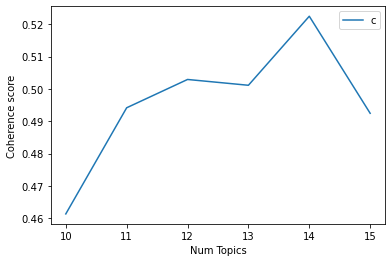

 [0] Num Topics = 10  has Coherence Value of 0.4614
 [1] Num Topics = 11  has Coherence Value of 0.4942
 [2] Num Topics = 12  has Coherence Value of 0.5029
 [3] Num Topics = 13  has Coherence Value of 0.5011
 [4] Num Topics = 14  has Coherence Value of 0.5225
 [5] Num Topics = 15  has Coherence Value of 0.4925


In [4]:
coherences = Coherencio(base_df, 10, limit=16, step=1)
coherences.compute_coherence_values()
coherences.plot_coherences()

In [5]:
# si se hace con un solo num_topics se puede omitir
coherences.choose_best_model(4)
coherences.format_topics_documents()
coherences.count_per_topic()

Main topic: 100%|██████████| 14386/14386 [03:03<00:00, 78.56it/s]


2.0     2553
10.0    2315
6.0     2144
12.0    1898
11.0    1858
8.0     1814
13.0     534
0.0      436
5.0      297
1.0      172
7.0      149
4.0      139
9.0       71
3.0        6
Name: Dominant_Topic, dtype: int64

In [6]:
coherences.df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,12.0,0.6217,"post_on, instagrama_post, view_this, post_shar...","[lujoso, auto, mundo, enamorar, convertido, in..."
1,1,13.0,0.4308,"comuna, fase, común, cuarentena, paso, alcalde...","[comercio, preocupado, retroceso, fase, manife..."
2,2,2.0,0.7146,"persona, hora, realizar, lugar, semana, fin, q...","[detener, persona, protestar, afuera, catedral..."
3,3,2.0,0.6184,"persona, hora, realizar, lugar, semana, fin, q...","[minsal, detallar, protocolo, uso, piscina, ci..."
4,4,11.0,0.3123,"hacer, decir, mas, ver, ano, gente, solo, quer...","[extorsionar, espantoso, virginia_demario, lag..."
...,...,...,...,...,...
14381,14381,6.0,0.2390,"ministro, hacer, proyecto, decir, presidente, ...","[residente, inadmitido, intentar, ingresar, pa..."
14382,14382,6.0,0.2964,"ministro, hacer, proyecto, decir, presidente, ...","[llamar, investigar, cobro, luminaria, realiza..."
14383,14383,8.0,0.7516,"caso, nuevo, contagio, total, persona, cifra, ...","[bio_bio, registrar, caso, nuevo, balance, min..."
14384,14384,8.0,0.4918,"caso, nuevo, contagio, total, persona, cifra, ...","[informe_epidemiologico, fallecido, llegarian_..."


### Nos enfocaremos en las categorias que poseen menos noticias hasta el momento

del paso anterior:

```
                category 	count(*)
                
                
1-Mundo                         8609
9-Crimen_delitos_y_Justicia 	8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
```

In [7]:
coherences.get_best_model_keywords()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,politico,vivo,persona,transporte,colegio,sismo,ministro,aumento,caso,entrevista,ano,hacer,post_on,comuna
1,presidente,serie,hora,vacuna,clase,profesor,hacer,semana,nuevo,nota_tabla_emol_tablaennoticio,nuevo,decir,instagrama_post,fase
2,plebiscito,historia,realizar,marzo,estudiante,norte,proyecto,nivel,contagio,tr_td,mas,mas,view_this,común
3,votar,nuevo,lugar,listo,presencial,zona,decir,mayor,total,mutual,estudio,ver,post_shared,cuarentena
4,proceso,personaje,semana,servicio,volver,hora,presidente,transmision,persona,text_align,millón,ano,ano,paso
5,violencia,junto,fin,bus,alumno,magnitud,sostener,cifra,cifra,rector,primero,gente,shared_by,alcalde
6,derecho,programa,quedar,operativo,escuela,generar,asegurar,bajo,casos_activo,contingencia,contar,solo,hijo,region
7,participacion,temporada,encontrar,tren,escolar,temblor,situacion,mes,salud,tr_th,espacio,querer,actriz,permiso
8,elección,noviembre,carabinero,disponible,educacion,region,acuerdo,alto,paciente,distrito,equipo,bien,vida,medida
9,mesa,director,medida,insistir,clases_presencial,costa,parte,aumentar,fallecido,tablaennoticia_tr,mayor,vez,famoso,pasar


Observamos las palabras principales de cada tópico y descartamos aquellos que corresponden a categorías más numerosas:

In [8]:
important_topics = [ 1, 4, 5, 10, 11, 12]

In [9]:
df_topics = base_df.copy()
mask = coherences.df_dominant_topic.Dominant_Topic.isin(important_topics)
df_topics = df_topics[mask.reindex(df_topics.index, fill_value=False)]
df_topics.reset_index(inplace=True)
df_topics.drop(columns=['index'], inplace=True)
df_topics

,id,url,title,content,text_list
0,7317217,https://www.meganoticias.cl/tendencias/323633-...,Desde un lujoso auto hasta viajes por el mundo...,Desde un lujoso auto hasta viajes por el mundo...,"['lujoso', 'auto', 'mundo', 'enamorar', 'conve..."
1,7323819,https://www.meganoticias.cl/tendencias/321922-...,"""Me están extorsionando, es espantoso"": Virgin...","""Me están extorsionando, es espantoso"": Virgin...","['extorsionar', 'espantoso', 'virginia_demario..."
2,7356975,https://www.meganoticias.cl/tendencias/312694-...,"Julio Iglesias sobre su salud: ""Casi me rompo ...","Julio Iglesias sobre su salud: ""Casi me rompo ...","['julio_iglesia', 'salud', 'casi', 'rompo', 'p..."
3,7352895,https://www.meganoticias.cl/tendencias/313969-...,Vamos Chilenos: Daniel Fuenzalida dio testimon...,Vamos Chilenos: Daniel Fuenzalida dio testimon...,"['ir', 'chileno', 'dar', 'testimonio', 'intern..."
4,6535056,https://www.latercera.com/opinion/noticia/a-qu...,¿A qué le temen?,"¿A qué le temen?. El domingo pasado, Pablo Lon...","['temer', 'domingo', 'pasado', 'dar', 'entrevi..."
...,...,...,...,...,...
6674,7646021,https://www.meganoticias.cl/calidad-de-vida/32...,Fact Checking: ¿Bill Gates busca reducir la po...,Fact Checking: ¿Bill Gates busca reducir la po...,"['fact_checking', 'bill_gat', 'buscar', 'reduc..."
6675,6523376,https://www.latercera.com/opinion/noticia/ni-m...,Ni miedo ni ingenuidad,Ni miedo ni ingenuidad. La votación del día do...,"['miedo', 'ingenuidad', 'votacion', 'dia', 'do..."
6676,3794700,https://www.elciudadano.com/actualidad/correa-...,Correa confía en victoria de binomio Arauz-Rab...,Correa confía en victoria de binomio Arauz-Rab...,"['correa', 'confia', 'victoria', 'binomio', 'e..."
6677,1383623,https://www.biobiochile.cl/noticias/sociedad/d...,México pide explicaciones a famosa diseñadora ...,México pide explicaciones a famosa diseñadora ...,"['pedir', 'explicación', 'famoso', 'disenadoro..."


### Repetimos el proceso anterior ahora para una cantidad mas acotada de topicos y con un mayor rango de búsqueda para la coeherencia

In [10]:
# quitaremos algunas palabras que no entregan mucha informacion
stop_words = ['persona', 'post_on', 'instagrama_post', 'view_this', 'post_shared',
              'shared_by', 'by', 'ano', 'hacer', 'decir', 'ver', 'dar',
              'mas', 'tambien', 'bien', 'querer', 'tener', 'gente', 'vivo', 'pic_twitter']

LDA MODELS: 100%|██████████| 12/12 [18:48<00:00, 94.03s/it] 


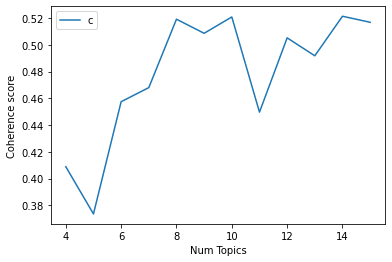

 [0] Num Topics = 4  has Coherence Value of 0.4089
 [1] Num Topics = 5  has Coherence Value of 0.3736
 [2] Num Topics = 6  has Coherence Value of 0.4575
 [3] Num Topics = 7  has Coherence Value of 0.4680
 [4] Num Topics = 8  has Coherence Value of 0.5192
 [5] Num Topics = 9  has Coherence Value of 0.5086
 [6] Num Topics = 10  has Coherence Value of 0.5208
 [7] Num Topics = 11  has Coherence Value of 0.4497
 [8] Num Topics = 12  has Coherence Value of 0.5052
 [9] Num Topics = 13  has Coherence Value of 0.4918
 [10] Num Topics = 14  has Coherence Value of 0.5214
 [11] Num Topics = 15  has Coherence Value of 0.5169


In [11]:
coherences = Coherencio(df_topics, 4, limit=16, step=1, stop_words=stop_words)
coherences.compute_coherence_values()
coherences.plot_coherences()

In [12]:
coherences.choose_best_model(4)
coherences.format_topics_documents()
coherences.count_per_topic()

Main topic: 100%|██████████| 6679/6679 [00:57<00:00, 115.70it/s]


2.0    1479
5.0    1478
4.0    1384
7.0    1217
0.0     545
6.0     401
1.0     127
3.0      48
Name: Dominant_Topic, dtype: int64

### Analizamos las palabras claves y algunas noticias de cada topico

In [13]:
coherences.get_best_model_keywords()

,0,1,2,3,4,5,6,7
0,agua,colegio,nuevo,salud,creer,vida,sismo,video
1,encontrar,estudiante,proyecto,enfermedad,politico,primero,zona,junto
2,cientifico,clase,mayor,contagio,presidente,serie,hora,artista
3,animal,volver,trabajo,virus,hoy,historia,magnitud,foto
4,humano,alumno,nacional,medico,caso,mujer,temblor,redes_social
5,lugar,profesor,nivel,paciente,ir,contar,generar,dejar
6,explicar,presencial,realizar,caso,seguir,familia,region,seguidor
7,solo,escuela,espacio,tratamiento,pasar,nuevo,norte,famoso
8,vez,clases_presencial,parte,entrevista,solo,momento,costa,cantante
9,planeta,escolar,director,mental,vez,parte,kilometro,nuevo


In [17]:
pd.set_option('display.max_colwidth', 200)
# por ejemplo vemos noticias del topico 3, posiblemente categoria salud
mask = coherences.df_dominant_topic['Dominant_Topic'] == 3
df_topics.reset_index()[mask].head(5)

,index,id,url,title,content,text_list
43,43,6230161,https://www.elciudadano.com/actualidad/cientificos-desarrollan-el-primer-metodo-del-mundo-para-detectar-el-tinnitus-un-constante-ruido-en-la-cabeza/11/20/,"Científicos desarrollan el primer método del mundo para detectar el tinnitus, un constante ruido en la cabeza","Científicos desarrollan el primer método del mundo para detectar el tinnitus, un constante ruido en la cabeza. Utilizando una técnica de imágenes no invasiva y no radiactiva, los científicos han d...","['cientifico', 'desarrollar', 'primero', 'metodo', 'mundo', 'detectar', 'tinnitus', 'constante', 'ruido', 'cabeza', 'utilizar', 'tecnico', 'imagen', 'invasivo', 'radiactiva', 'cientifico', 'desarr..."
108,108,13485835,https://www.emol.com/noticias/Nacional/2020/10/01/999498/Corte-Suprema-Integrantes-Adelita-Ravanales.html,Cómo queda conformada la Corte Suprema tras la designación de la jueza Adelita Ravanales,"Cómo queda conformada la Corte Suprema tras la designación de la jueza Adelita Ravanales. #emolmlt-bajada { font-family: Arial, Helvetica, sans-serif; font-size: 14px; line-height: 20px; display...","['quedar', 'conformado', 'corte_supremar', 'designacion', 'jueza', 'adelita_ravanal', 'emolmlt_bajado', 'font_family', 'arial_helvetica', 'sans_serif', 'font_size', 'display_block', 'px_padding', ..."
478,478,13370379,https://www.emol.com/noticias/Nacional/2021/03/02/1013700/Medicina-carreras-salud-mas-demandadas.html,Carreras de la salud lideraron preferencias de postulantes: La más demandada fue Medicina en la Usach,Carreras de la salud lideraron preferencias de postulantes: La más demandada fue Medicina en la Usach. SANTIAGO.- Las carreras relacionadas con la salud volvieron a atraer con fuerza a quienes p...,"['carrera', 'salud', 'liderar', 'preferencia', 'postulant', 'demandado', 'medicina', 'carrera', 'relacionado', 'salud', 'volver', 'atraer', 'fuerza', 'postular', 'universidad', 'ano', 'segun', 'mo..."
552,552,7647337,https://www.meganoticias.cl/calidad-de-vida/313135-sindrome-intestino-irritable-detonantes-causas-ppx03.html,Colon Irritable: Estos son los detonantes que causan la enfermedad,"Colon Irritable: Estos son los detonantes que causan la enfermedad. El Síndrome del Intestino Irritable (SII), también conocido como ""colon irritable"", es un trastorno funcional digestivo, que se...","['colon_irritable', 'detonant', 'causar', 'enfermedad', 'sindrome', 'intestino', 'irritable', 'conocido', 'colon_irritable', 'trastorno', 'funcional', 'digestivo', 'manifestar', 'alteración', 'fun..."
648,648,13424988,https://www.emol.com/noticias/Nacional/2020/12/22/1007337/Corte-Suprema-Integrantes-Ministros-Jueces.html,Trece hombres y ocho mujeres: Cómo queda conformada la Corte Suprema tras la ratificación de Mario Carroza,"Trece hombres y ocho mujeres: Cómo queda conformada la Corte Suprema tras la ratificación de Mario Carroza. #emolmlt-bajada { font-family: Arial, Helvetica, sans-serif; font-size: 14px; line-hei...","['hombre', 'mujer', 'quedar', 'conformado', 'corte_supremar', 'ratificacion', 'emolmlt_bajado', 'font_family', 'arial_helvetica', 'sans_serif', 'font_size', 'display_block', 'px_padding', 'px', 'p..."


In [18]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""



dfs = []
for i in [0, 3, 5, 6]: #planeta/catastrofes, cultura?, salud
    mask = coherences.df_dominant_topic['Dominant_Topic'] == i
    _df = df_topics.reset_index()[mask]
    dfs.append(_df)

dfs[0].head(3)

,index,id,url,title,content,text_list
35,35,6796816,https://www.latercera.com/masdeco/totomoxtle/,Totomoxtle,Totomoxtle. Fernando Laposse / 2020 Si hay algo grandioso que América regaló a las cocinas del mundo fue el maíz. Basta pensar solamente en nuestros pasteles de choclo o la polenta en Italia. La m...,"['lapossir', 'grandioso', 'regalo', 'cocina', 'mundo', 'bastar', 'pensar', 'solamente', 'pastel', 'mayor', 'variedad', 'semilla', 'provenir', 'siempre', 'glorioso', 'grano', 'parte', 'fundamental'..."
38,38,5152832,https://www.elciudadano.com/actualidad/botellas-con-antenas-metodo-comprender-contaminacion-plastico/12/03/,Botellas con antenas: un método para comprender la contaminación con plástico,"Botellas con antenas: un método para comprender la contaminación con plástico. En el mundo, los ríos acarrean casi 80 % de los cientos de millones de toneladas de plástico que contaminan los océan...","['botella', 'antena', 'metodo', 'comprender', 'contaminacion', 'plastico', 'mundo', 'rio', 'acarrear', 'casi', 'millón', 'tonelada', 'plastico', 'contaminar', 'oceano', 'pieza', 'grande', 'bolsa',..."
39,39,7347932,https://www.meganoticias.cl/tendencias/315470-planetas-habitables-tierra-universo-rpx04.html,Detectan 24 planetas con mejores condiciones para vivir que la Tierra,Detectan 24 planetas con mejores condiciones para vivir que la Tierra. Un estudio de la Universidad Estatal de Washington detectó que existen 24 planetas con mejores condiciones para vivir que la ...,"['detectar', 'planeta', 'mejor', 'condición', 'vivir', 'tierra', 'estudio', 'estatal', 'existir', 'planeta', 'mejor', 'condición', 'vivir', 'tierra', 'medio', 'busquedar', 'cuerpos_celest', 'super..."


### LDA definitivo, partiendo por el topico que podria contener noticias de planeta y ciencia

LDA MODELS: 100%|██████████| 6/6 [00:29<00:00,  4.87s/it]


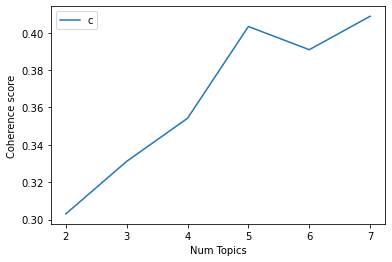

 [0] Num Topics = 2  has Coherence Value of 0.3030
 [1] Num Topics = 3  has Coherence Value of 0.3312
 [2] Num Topics = 4  has Coherence Value of 0.3542
 [3] Num Topics = 5  has Coherence Value of 0.4033
 [4] Num Topics = 6  has Coherence Value of 0.3909
 [5] Num Topics = 7  has Coherence Value of 0.4088


In [21]:
coherences_a = Coherencio(dfs[0], 2, limit=8, step=1, stop_words=stop_words)
coherences_a.compute_coherence_values()
coherences_a.plot_coherences()

In [22]:
coherences_a.choose_best_model(3)
coherences_a.format_topics_documents()
coherences_a.count_per_topic()

Main topic: 100%|██████████| 545/545 [00:03<00:00, 169.26it/s]


4.0    152
3.0    115
1.0    113
2.0     87
0.0     78
Name: Dominant_Topic, dtype: int64

In [23]:
coherences_a.get_best_model_keywords()

,0,1,2,3,4
0,estrella,tierra,investigador,fenomeno,animal
1,nuevo,planeta,humano,zona,especie
2,planeta,vida,virus,sol,agua
3,cientifico,primero,estudio,eclipse,zona
4,investigador,cientifico,solo,total,encontrar
5,explicar,solar,salud,temperatura,ballena
6,primero,vez,enfermedad,lluvia,presencia
7,estudio,millón,usar,parte,gato
8,tanto,nás,plastico,hora,estudio
9,luz,espacial,tiempo,solo,caso


In [24]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# yolo
cats_dict_a = {0 : '4-Ciencias_y_Tecnología',
             1 : '4-Ciencias_y_Tecnología',
             2 : '8-Ecología_y_Planeta',
             3 : '8-Ecología_y_Planeta',
             4 : '8-Ecología_y_Planeta',
             }


for i in range(coherences.optimal_ntopics):
    if i not in cats_dict_a.keys():
        cats_dict_a[i] = np.nan
        
cats_dict_a

{0: '4-Ciencias_y_Tecnología',
 1: '4-Ciencias_y_Tecnología',
 2: '8-Ecología_y_Planeta',
 3: '8-Ecología_y_Planeta',
 4: '8-Ecología_y_Planeta',
 5: nan,
 6: nan,
 7: nan}

In [25]:
df_a = dfs[0].copy()
df_a.reset_index(inplace=True)
df_a['dominant_topic'] = coherences.df_dominant_topic['Dominant_Topic']
df_a.to_csv('./intermediate_data/df_a_paso_2.csv', index=False)
df_a.head(3)

,level_0,index,id,url,title,content,text_list,dominant_topic
0,35,35,6796816,https://www.latercera.com/masdeco/totomoxtle/,Totomoxtle,Totomoxtle. Fernando Laposse / 2020 Si hay algo grandioso que América regaló a las cocinas del mundo fue el maíz. Basta pensar solamente en nuestros pasteles de choclo o la polenta en Italia. La m...,"['lapossir', 'grandioso', 'regalo', 'cocina', 'mundo', 'bastar', 'pensar', 'solamente', 'pastel', 'mayor', 'variedad', 'semilla', 'provenir', 'siempre', 'glorioso', 'grano', 'parte', 'fundamental'...",7.0
1,38,38,5152832,https://www.elciudadano.com/actualidad/botellas-con-antenas-metodo-comprender-contaminacion-plastico/12/03/,Botellas con antenas: un método para comprender la contaminación con plástico,"Botellas con antenas: un método para comprender la contaminación con plástico. En el mundo, los ríos acarrean casi 80 % de los cientos de millones de toneladas de plástico que contaminan los océan...","['botella', 'antena', 'metodo', 'comprender', 'contaminacion', 'plastico', 'mundo', 'rio', 'acarrear', 'casi', 'millón', 'tonelada', 'plastico', 'contaminar', 'oceano', 'pieza', 'grande', 'bolsa',...",4.0
2,39,39,7347932,https://www.meganoticias.cl/tendencias/315470-planetas-habitables-tierra-universo-rpx04.html,Detectan 24 planetas con mejores condiciones para vivir que la Tierra,Detectan 24 planetas con mejores condiciones para vivir que la Tierra. Un estudio de la Universidad Estatal de Washington detectó que existen 24 planetas con mejores condiciones para vivir que la ...,"['detectar', 'planeta', 'mejor', 'condición', 'vivir', 'tierra', 'estudio', 'estatal', 'existir', 'planeta', 'mejor', 'condición', 'vivir', 'tierra', 'medio', 'busquedar', 'cuerpos_celest', 'super...",7.0


In [26]:
df_a['category'] = df_a.apply(lambda row : cats_dict_a[row.dominant_topic], axis=1)
df_a.dropna(subset=['category'], inplace=True)

In [27]:
df_a.groupby(by='category').size()

category
4-Ciencias_y_Tecnología     46
8-Ecología_y_Planeta       245
dtype: int64

In [ ]:
file_idx = 0
df_a[['id', 'url', 'title', 'content', 'category']].to_csv(f'./datasets/df_paso_2_{file_idx}.csv', index=False)
file_idx += 1
file_idx

2

In [52]:
del df_a, coherences_a

### LDA definitivo, segundo subset (salud)

LDA MODELS: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


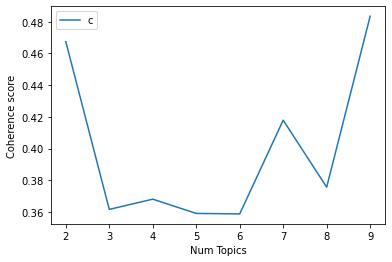

 [0] Num Topics = 2  has Coherence Value of 0.4674
 [1] Num Topics = 3  has Coherence Value of 0.3616
 [2] Num Topics = 4  has Coherence Value of 0.3681
 [3] Num Topics = 5  has Coherence Value of 0.3591
 [4] Num Topics = 6  has Coherence Value of 0.3588
 [5] Num Topics = 7  has Coherence Value of 0.4179
 [6] Num Topics = 8  has Coherence Value of 0.3757
 [7] Num Topics = 9  has Coherence Value of 0.4835


In [30]:
coherences_b = Coherencio(dfs[1], 2, limit=10, step=1, stop_words=stop_words)
coherences_b.compute_coherence_values()
coherences_b.plot_coherences()

In [31]:
coherences_b.choose_best_model(0)
coherences_b.format_topics_documents()
coherences_b.count_per_topic()

Main topic: 100%|██████████| 48/48 [00:00<00:00, 151.96it/s]


1.0    32
0.0    16
Name: Dominant_Topic, dtype: int64

In [32]:
coherences_b.get_best_model_keywords()

,0,1
0,entrevista,enfermedad
1,edad,estudio
2,estudio,nivel
3,nominado,consumo
4,mascarilla,paciente
5,presidente,tratamiento
6,ministro,alto
7,transmision,cerebro
8,seguridad,salud
9,ex,generar


In [33]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# yolo
cats_dict_b = {
    1 : '10-Salud'
}

for i in range(coherences_b.optimal_ntopics):
    if i not in cats_dict_b.keys():
        cats_dict_b[i] = np.nan
        
cats_dict_b

{1: '10-Salud', 0: nan}

In [37]:
df_b = dfs[1].copy()
df_b.reset_index(inplace=True)
df_b['dominant_topic'] = coherences_b.df_dominant_topic['Dominant_Topic']
df_b.to_csv('./intermediate_data/df_b_paso_2.csv', index=False)
df_b.head(3)

,level_0,index,id,url,title,content,text_list,dominant_topic
0,43,43,6230161,https://www.elciudadano.com/actualidad/cientificos-desarrollan-el-primer-metodo-del-mundo-para-detectar-el-tinnitus-un-constante-ruido-en-la-cabeza/11/20/,"Científicos desarrollan el primer método del mundo para detectar el tinnitus, un constante ruido en la cabeza","Científicos desarrollan el primer método del mundo para detectar el tinnitus, un constante ruido en la cabeza. Utilizando una técnica de imágenes no invasiva y no radiactiva, los científicos han d...","['cientifico', 'desarrollar', 'primero', 'metodo', 'mundo', 'detectar', 'tinnitus', 'constante', 'ruido', 'cabeza', 'utilizar', 'tecnico', 'imagen', 'invasivo', 'radiactiva', 'cientifico', 'desarr...",1.0
1,108,108,13485835,https://www.emol.com/noticias/Nacional/2020/10/01/999498/Corte-Suprema-Integrantes-Adelita-Ravanales.html,Cómo queda conformada la Corte Suprema tras la designación de la jueza Adelita Ravanales,"Cómo queda conformada la Corte Suprema tras la designación de la jueza Adelita Ravanales. #emolmlt-bajada { font-family: Arial, Helvetica, sans-serif; font-size: 14px; line-height: 20px; display...","['quedar', 'conformado', 'corte_supremar', 'designacion', 'jueza', 'adelita_ravanal', 'emolmlt_bajado', 'font_family', 'arial_helvetica', 'sans_serif', 'font_size', 'display_block', 'px_padding', ...",0.0
2,478,478,13370379,https://www.emol.com/noticias/Nacional/2021/03/02/1013700/Medicina-carreras-salud-mas-demandadas.html,Carreras de la salud lideraron preferencias de postulantes: La más demandada fue Medicina en la Usach,Carreras de la salud lideraron preferencias de postulantes: La más demandada fue Medicina en la Usach. SANTIAGO.- Las carreras relacionadas con la salud volvieron a atraer con fuerza a quienes p...,"['carrera', 'salud', 'liderar', 'preferencia', 'postulant', 'demandado', 'medicina', 'carrera', 'relacionado', 'salud', 'volver', 'atraer', 'fuerza', 'postular', 'universidad', 'ano', 'segun', 'mo...",1.0


In [38]:
df_b['category'] = df_b.apply(lambda row : cats_dict_b[row.dominant_topic], axis=1)
df_b.dropna(subset=['category'], inplace=True)
df_b.columns

Index(['level_0', 'index', 'id', 'url', 'title', 'content', 'text_list',
       'dominant_topic', 'category'],
      dtype='object')

In [39]:
df_b[['id', 'url', 'title', 'content', 'category']].to_csv(f'./datasets/df_paso_2_{file_idx}.csv', index=False)
file_idx += 1
file_idx

2

In [40]:
df_b.groupby(by='category').size()

category
10-Salud    32
dtype: int64

In [41]:
del df_b, coherences_b

### LDA definitivo, tercer subset (???)

LDA MODELS: 100%|██████████| 8/8 [01:47<00:00, 13.49s/it]


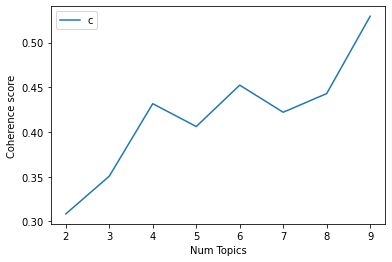

 [0] Num Topics = 2  has Coherence Value of 0.3084
 [1] Num Topics = 3  has Coherence Value of 0.3506
 [2] Num Topics = 4  has Coherence Value of 0.4317
 [3] Num Topics = 5  has Coherence Value of 0.4062
 [4] Num Topics = 6  has Coherence Value of 0.4525
 [5] Num Topics = 7  has Coherence Value of 0.4222
 [6] Num Topics = 8  has Coherence Value of 0.4430
 [7] Num Topics = 9  has Coherence Value of 0.5296


In [42]:
coherences_c = Coherencio(dfs[2], 2, limit=10, step=1, stop_words=stop_words)
coherences_c.compute_coherence_values()
coherences_c.plot_coherences()

In [45]:
coherences_c.choose_best_model(4)
coherences_c.format_topics_documents()
coherences_c.count_per_topic()

Main topic: 100%|██████████| 1478/1478 [00:09<00:00, 158.36it/s]


2.0    549
3.0    434
5.0    273
1.0    143
0.0     77
4.0      2
Name: Dominant_Topic, dtype: int64

In [46]:
coherences_c.get_best_model_keywords()

,0,1,2,3,4,5
0,edificio_coronar,mejor,vida,serie,jason_earl,mujer
1,mega,chileno,hijo,actor,rbd,ahora
2,teleserie,concierto,familia,personaje,reencuentro,nuevo
3,actriz,mundo,momento,actriz,cantautor,vez
4,personaje,primero,luego,nuevo,christian_chavez,pasar
5,teleseries_mego,musical,contar,estreno,connery,hablar
6,teatro,festival,junto,historia,quino,tiempo
7,pantalla,jugador,solo,temporada,dulce_mario,volver
8,edificiocorón,gran,primero,primero,robl,siempre
9,edificiocoronar,publico,muerte,netflix,today,solo


In [47]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# yolo
cats_dict_c = {
    1 : '6-Cultura_y_Artes',
    3 : '6-Cultura_y_Artes',
}

for i in range(coherences_c.optimal_ntopics):
    if i not in cats_dict_c.keys():
        cats_dict_c[i] = np.nan
        
cats_dict_c

{1: '6-Cultura_y_Artes',
 3: '6-Cultura_y_Artes',
 0: nan,
 2: nan,
 4: nan,
 5: nan}

In [48]:
df_c = dfs[2].copy()
df_c.reset_index(inplace=True)
df_c['dominant_topic'] = coherences_c.df_dominant_topic['Dominant_Topic']
df_c.to_csv('./datasets/df_c_paso_2.csv', index=False)
df_c.head(3)

,level_0,index,id,url,title,content,text_list,dominant_topic
0,6,6,7308822,https://www.meganoticias.cl/tendencias/325368-edificio-corona-elenco-simon-beltran-nicolas-oyarzun-instagram-pox09.html,"La broma de Nicolás Oyarzún a Simón Beltrán en medio de las grabaciones de ""Edificio Corona""","La broma de Nicolás Oyarzún a Simón Beltrán en medio de las grabaciones de ""Edificio Corona"". Desde el debut de “Edificio Corona”, uno de los personaje que se ha robado el corazón de muchos es el ...","['broma', 'nicolas_oyarzun', 'simon_beltran', 'medio', 'grabación', 'edificio_coronar', 'debut', 'edificio_coronar', 'personaje', 'robado', 'interpretado', 'actor', 'nicolas_oyarzun', 'cautivado',...",5.0
1,8,8,7351435,https://www.meganoticias.cl/tendencias/314327-te-doy-la-vida-elenco-cristian-riquelme-leon-izquierdo-nicolas-nino-beltran-leucemia-pox09.html,"Así está actualmente el pequeño Nicolás de ""Te doy la vida""","Así está actualmente el pequeño Nicolás de ""Te doy la vida"". El reciente lunes 21 de septiembre se vivió el reestreno de una nueva teleserie de Mega. Se trata de ""Te doy la vida"", emitida en 2016 ...","['actualmente', 'pequeno', 'nicola', 'dar', 'vida', 'reciente', 'lunes', 'septiembre', 'viver', 'reestreno', 'nuevo', 'teleserie', 'tratar', 'doy', 'vida', 'emitido', 'protagonizado', 'cristian_ri...",2.0
2,22,22,7336394,https://www.meganoticias.cl/tendencias/318907-patricia-lopez-rios-genesis-reparto-pituca-sin-lucas-pox09.html,"La ""hermana"" Génesis: Esta es la actriz tras el popular personaje de ""Pituca sin lucas""","La ""hermana"" Génesis: Esta es la actriz tras el popular personaje de ""Pituca sin lucas"". Por estos días vemos a través de las pantallas de Mega la historia de Gregorio Cereceda (Fernando Godoy), e...","['hermana', 'genesis', 'popular', 'personaje', 'ver', 'trav', 'pantalla', 'mega', 'fernando_godoy', 'religioso', 'timido', 'genesis', 'conquista', 'atributo', 'fisico', 'llevar', 'comprometer él',...",0.0


In [49]:
df_c['category'] = df_c.apply(lambda row : cats_dict_c[row.dominant_topic], axis=1)
df_c.dropna(subset=['category'], inplace=True)
df_c.columns

Index(['level_0', 'index', 'id', 'url', 'title', 'content', 'text_list',
       'dominant_topic', 'category'],
      dtype='object')

In [53]:
df_c[['id', 'url', 'title', 'content', 'category']].to_csv(f'./datasets/df_paso_2_{file_idx}.csv', index=False)
file_idx += 1

In [54]:
df_c.groupby(by='category').size()

category
6-Cultura_y_Artes    577
dtype: int64

### LDA definitivo, cuarto subset posiblemente catastrofes

LDA MODELS: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


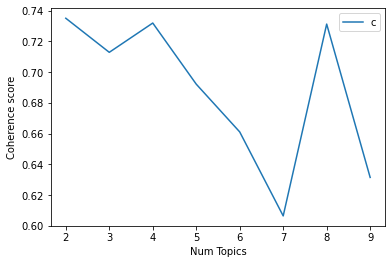

 [0] Num Topics = 2  has Coherence Value of 0.7351
 [1] Num Topics = 3  has Coherence Value of 0.7129
 [2] Num Topics = 4  has Coherence Value of 0.7320
 [3] Num Topics = 5  has Coherence Value of 0.6922
 [4] Num Topics = 6  has Coherence Value of 0.6611
 [5] Num Topics = 7  has Coherence Value of 0.6064
 [6] Num Topics = 8  has Coherence Value of 0.7313
 [7] Num Topics = 9  has Coherence Value of 0.6315


In [55]:
coherences_d = Coherencio(dfs[3], 2, limit=10, step=1, stop_words=stop_words)
coherences_d.compute_coherence_values()
coherences_d.plot_coherences()

In [56]:
coherences_d.choose_best_model(6)
coherences_d.format_topics_documents()
coherences_d.count_per_topic()

Main topic: 100%|██████████| 401/401 [00:02<00:00, 194.53it/s]


5.0    170
3.0     75
2.0     61
1.0     59
0.0     20
4.0     13
7.0      3
Name: Dominant_Topic, dtype: int64

In [57]:
coherences_d.get_best_model_keywords()

,0,1,2,3,4,5,6,7
0,sabor,alimento,sismo,lat_lon,precipitación,sismo,cliente,mascota
1,agregar,salud,zona,hora,lluvia,generar,celebración,gato
2,queso,beneficio,temblor,prof_loc,milimetro,condiciones_necesaria,presentario,magnitud_localizado
3,poner,alto,magnitud,sismo,esperar,temblor,rancaguo,perro
4,aceite,consumo,fuerte,centro_sismologico,agua,costa,registrir,comer
5,carne,vitamina,replica,zona,dia,tsunami,fiestas_patria,comida
6,buen,aportar,parte,norte,llegar,reunir,goterón,alimento
7,taza,duda,region,reportan_dano,pesar,kilometro,reportir,edulcorant
8,receta,tratamiento,nacional,magnitud,semana,caracteristica,arranque,veterinario
9,plato,vegetal,terremoto,preliminarmente,alto,grado,agradable,dar él


In [58]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# yolo
cats_dict_d = {
    1 : '10-Salud',
    2 : '5-Catástrofes_y_Accidentes',
    3 : '5-Catástrofes_y_Accidentes',
    4 : '8-Ecología_y_Planeta',
    5 : '5-Catástrofes_y_Accidentes',
    7 : '8-Ecología_y_Planeta',
}

for i in range(coherences_d.optimal_ntopics):
    if i not in cats_dict_d.keys():
        cats_dict_d[i] = np.nan
        
cats_dict_d

{1: '10-Salud',
 2: '5-Catástrofes_y_Accidentes',
 3: '5-Catástrofes_y_Accidentes',
 4: '8-Ecología_y_Planeta',
 5: '5-Catástrofes_y_Accidentes',
 7: '8-Ecología_y_Planeta',
 0: nan,
 6: nan}

In [59]:
df_d = dfs[3].copy()
df_d.reset_index(inplace=True)
df_d['dominant_topic'] = coherences_d.df_dominant_topic['Dominant_Topic']
df_d.to_csv('./datasets/df_c_paso_2.csv', index=False)
df_d.head(3)

,level_0,index,id,url,title,content,text_list,dominant_topic
0,52,52,3971743,https://www.meganoticias.cl/nacional/319009-temblor-socaire-region-antofagasta-chile-sismo-sismologia-nacional-onemi-jrx07.html,Temblor afecta a la región de Antofagasta,"Temblor afecta a la región de Antofagasta. Durante la tarde de este domingo se registró un sismo de 4,2 grados en la región de Antofagasta , cuando el reloj marcaba las 20:19 horas. El movimiento ...","['temblor_afecto', 'region', 'antofagasta', 'tarde', 'domingo', 'registro', 'sismo', 'grado', 'antofagasta', 'reloj_marcar', 'hora', 'movimiento_telurico', 'segun', 'informacion_proporcionado', 'c...",5.0
1,67,67,13330235,https://www.emol.com/noticias/Nacional/2021/04/19/1018336/Meteorologia-en-Chile.html,Meteorología anuncia lluvia para la RM: Comenzaría mañana y se extendería hasta el miércoles,Meteorología anuncia lluvia para la RM: Comenzaría mañana y se extendería hasta el miércoles. La Dirección Meteorológica de Chile (DMC) anunció lluvia para este martes y miércoles en Región Metro...,"['anunciar', 'lluvia', 'comenzariar', 'manana', 'extenderio', 'miercoles', 'anuncio', 'lluvia', 'martes', 'miercoles', 'region_metropolitán', 'precipitacion', 'debil', 'mas', 'significativo', 'pen...",2.0
2,75,75,7645941,https://www.meganoticias.cl/calidad-de-vida/322074-como-reconocer-a-un-gato-obeso-1ab.html,Aprende a reconocer la obesidad en los gatos: Estas son cinco señales visibles,"Aprende a reconocer la obesidad en los gatos: Estas son cinco señales visibles. Ya sea por su pelaje, por su raza o por la edad, se hace cuesta arriba reconocer si un gato está pasado de peso. Más...","['aprender', 'reconocer', 'obesidad', 'gato', 'senal', 'visible', 'pelaje', 'raza', 'edad', 'hacer', 'cuesta_arribo', 'reconocer', 'gato', 'pasado', 'peso', 'indicar', 'bascula', 'existir', 'senal...",7.0


In [60]:
df_d['category'] = df_d.apply(lambda row : cats_dict_d[row.dominant_topic], axis=1)
df_d.dropna(subset=['category'], inplace=True)
df_d.columns

Index(['level_0', 'index', 'id', 'url', 'title', 'content', 'text_list',
       'dominant_topic', 'category'],
      dtype='object')

In [61]:
df_d[['id', 'url', 'title', 'content', 'category']].to_csv(f'./datasets/df_paso_2_{file_idx}.csv', index=False)
file_idx += 1
file_idx

4

In [62]:
df_d.groupby(by='category').size()

category
10-Salud                       59
5-Catástrofes_y_Accidentes    306
8-Ecología_y_Planeta           16
dtype: int64